In [ ]:
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets
from torch.utils.data import random_split
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

In [ ]:
SEED = 101

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_data = torchvision.datasets.CIFAR10(
    root = './train_data',
    download = True,
    transform = train_transforms
)

Files already downloaded and verified


In [ ]:
test_data = torchvision.datasets.CIFAR10(
    root = './test_data',
    download = True,
    transform = test_transforms
)

Files already downloaded and verified


In [ ]:
Valid_Ratio = 0.9

n_train_examples = int(len(train_data) * Valid_Ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
batch_size = 64

train_loader = data.DataLoader(train_data, shuffle = True,
                               batch_size = batch_size)

valid_loader = data.DataLoader(valid_data,
                               batch_size = batch_size)

test_loader = data.DataLoader(test_data,
                               batch_size = batch_size)

In [ ]:
class LeNet(nn.Module):
  def __init__(self, output_dim):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=output_dim)

  def forward(self, x):
    x = self.conv1(x)
    x = F.max_pool2d(x, kernel_size = 2)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.max_pool2d(x, kernel_size = 2)
    x = F.relu(x)

    x = x.view(-1, 16 * 5 * 5)

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)

    return x

In [ ]:
OUTPUT_DIM = 10
model = LeNet(OUTPUT_DIM)

In [ ]:
from torchinfo import summary

In [ ]:
summary(model, input_size = (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─Conv2d: 1-2                            [1, 16, 10, 10]           2,416
├─Linear: 1-3                            [1, 120]                  48,120
├─Linear: 1-4                            [1, 84]                   10,164
├─Linear: 1-5                            [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(pred, y):
  top_pred = pred.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  
  return acc

In [56]:
def train(model, dataloader, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  
  for features, labels in tqdm(dataloader, desc = "Training Phase", leave = False):
    features = features.to(device)
    labels = labels.to(device)

    pred = model(features)
    loss = criterion(pred, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = calculate_accuracy(pred, labels)
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion, device):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():

    for features, labels in tqdm(dataloader, desc = "Evaluation Phase", leave = False):
      
      features = features.to(device)
      labels = labels.to(device)

      pred = model(features)

      loss = criterion(pred, labels)

      acc = calculate_accuracy(pred, labels)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [59]:
EPOCH = 15

history = {
    'train_loss' : [],
    'train_acc' : [],
    'val_loss' : [],
    'vall_acc' : []
}

for epoch in trange(EPOCH, desc = "Epoch Number"):
  train_loss, train_acc = train(model, train_loader, optimizer , criterion, device)
  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)

  valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
  history['val_loss'].append(valid_loss)
  history['vall_acc'].append(valid_acc)

  print(f"Epoch :[{epoch + 1:2}]")
  print(f"\tTraining Loss : {train_loss : >7.3f} | Training Accuracy : {train_acc * 100 : >7.2f}%")
  print(f"\tValidation Loss : {valid_loss:>.3f} | Training Accouracy : {valid_loss * 100 : >7.2f}%")

Epoch Number:   0%|          | 0/15 [00:00<?, ?it/s]

Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[ 1]
	Training Loss :   1.276 | Training Accuracy :   54.27%
	Validation Loss : 1.248 | Training Accouracy :  124.75%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[ 2]
	Training Loss :   1.187 | Training Accuracy :   57.47%
	Validation Loss : 1.196 | Training Accouracy :  119.55%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[ 3]
	Training Loss :   1.115 | Training Accuracy :   60.27%
	Validation Loss : 1.166 | Training Accouracy :  116.60%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[ 4]
	Training Loss :   1.065 | Training Accuracy :   62.31%
	Validation Loss : 1.168 | Training Accouracy :  116.77%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[ 5]
	Training Loss :   1.014 | Training Accuracy :   63.95%
	Validation Loss : 1.095 | Training Accouracy :  109.48%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[ 6]
	Training Loss :   0.974 | Training Accuracy :   65.31%
	Validation Loss : 1.090 | Training Accouracy :  108.96%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[ 7]
	Training Loss :   0.934 | Training Accuracy :   66.73%
	Validation Loss : 1.138 | Training Accouracy :  113.77%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[ 8]
	Training Loss :   0.906 | Training Accuracy :   67.93%
	Validation Loss : 1.101 | Training Accouracy :  110.09%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[ 9]
	Training Loss :   0.867 | Training Accuracy :   69.36%
	Validation Loss : 1.090 | Training Accouracy :  109.02%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[10]
	Training Loss :   0.840 | Training Accuracy :   70.22%
	Validation Loss : 1.089 | Training Accouracy :  108.90%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[11]
	Training Loss :   0.811 | Training Accuracy :   71.25%
	Validation Loss : 1.094 | Training Accouracy :  109.36%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[12]
	Training Loss :   0.783 | Training Accuracy :   72.47%
	Validation Loss : 1.113 | Training Accouracy :  111.31%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[13]
	Training Loss :   0.763 | Training Accuracy :   72.99%
	Validation Loss : 1.106 | Training Accouracy :  110.63%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[14]
	Training Loss :   0.735 | Training Accuracy :   74.00%
	Validation Loss : 1.130 | Training Accouracy :  112.98%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch :[15]
	Training Loss :   0.710 | Training Accuracy :   74.88%
	Validation Loss : 1.166 | Training Accouracy :  116.62%


In [60]:
torch.save(model.state_dict(), 'cifar10.pt')

In [62]:
model.load_state_dict(torch.load('cifar10.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"Test Loss : {test_loss :.3f} | Test Accoyracy : {test_acc * 100 :.3f}%")

Evaluation Phase:   0%|          | 0/782 [00:00<?, ?it/s]

Test Loss : 0.726 | Test Accoyracy : 74.692%


In [66]:
def get_preds(model, dataloader, device):
    model.eval()

    images_list, labels_list, probs_list = [], [], []

    with torch.no_grad():

        for features, labels in dataloader:

            features = features.to(device)

            pred = model(features)

            prob = F.softmax(pred, dim=-1)

            images_list.append(features.cpu())
            labels_list.append(labels.cpu())
            probs_list.append(prob.cpu())

    images = torch.cat(images_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    probs = torch.cat(probs_list, dim=0)

    return images, labels, probs

In [67]:
images, labels, probs = get_preds(model, test_loader, device)

In [68]:
pred_labels = torch.argmax(probs, 1)

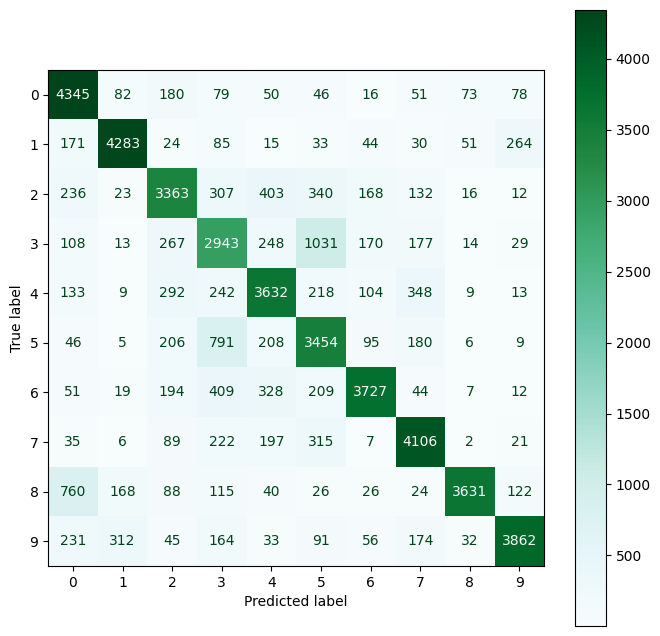

In [71]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
cm = confusion_matrix(labels, pred_labels)
cm = ConfusionMatrixDisplay(cm, display_labels = range(10))
cm.plot(values_format = 'd', cmap = 'BuGn', ax = ax)

In [72]:
print(train_data.dataset.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
